# Series Temporales

Una serie temporal es un conjunto de muestras tomadas a intervalos de tiempo regulares. Es interesante analizar su comportamiento al mediano y largo plazo, intentando detectar patrones y poder hacer pronósticos de cómo será su comportamiento futuro. Lo que hace <<especial>> a una Time Series a diferencia de un “problema” de Regresión son dos cosas:
    
Es dependiente del Tiempo. Esto rompe con el requerimiento que tiene la regresión lineal de que sus observaciones sean independientes.
    
Suelen tener algún tipo de estacionalidad, ó de tendencias a crecer ó decrecer. Pensemos en cuánto más producto vende una heladería en sólo 4 meses al año que en el resto de estaciones.

Ejemplo de series temporales son:
    
Capturar la temperatura, humedad y presión de una zona a intervalos de 15 minutos.

Valor de las acciones de una empresa en la bolsa minuto a minuto.

Ventas diarias (ó mensuales) de una empresa.

Producción en Kg de una cosecha cada semestre.

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
#%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler
#dayfirst=True
df = pd.read_csv('time_series.txt',  parse_dates=[0], header=None,index_col=0, squeeze=True,names=['fecha','unidades'])

df.head()

fecha
2017-01-02    236
2017-01-03    237
2017-01-04    290
2017-01-05    221
2017-01-07    128
Name: unidades, dtype: int64

In [39]:
print(df.index.min())
print(df.index.max())

2017-01-02 00:00:00
2018-11-30 00:00:00


Presumiblemente tenemos las ventas diarias de 2017 y de 2018 hasta el mes de noviembre. Y ahora veamos cuantas muestras tenemos de cada año:

In [40]:
print(len(df['2017']))
print(len(df['2018']))

315
289


# Visualización de datos

In [41]:
df.describe()

count    604.000000
mean     215.935430
std       75.050304
min       51.000000
25%      171.000000
50%      214.000000
75%      261.250000
max      591.000000
Name: unidades, dtype: float64

Son un total de 604 registros, la media de venta de unidades es de 215 y un desvío de 75, es decir que por lo general estaremos entre 140 y 290 unidades.

# indice de fechas con pandas y  promedios mensuales:

In [45]:
meses =df.resample('M').mean()
meses

fecha
2017-01-31    203.923077
2017-02-28    184.666667
2017-03-31    182.964286
2017-04-30    198.960000
2017-05-31    201.185185
2017-06-30    209.518519
2017-07-31    278.923077
2017-08-31    316.000000
2017-09-30    222.925926
2017-10-31    207.851852
2017-11-30    185.925926
2017-12-31    213.200000
2018-01-31    201.384615
2018-02-28    190.625000
2018-03-31    174.846154
2018-04-30    186.000000
2018-05-31    190.666667
2018-06-30    196.037037
2018-07-31    289.500000
2018-08-31    309.038462
2018-09-30    230.518519
2018-10-31    209.444444
2018-11-30    184.481481
Freq: M, Name: unidades, dtype: float64

# Visualización de medias mensuales:

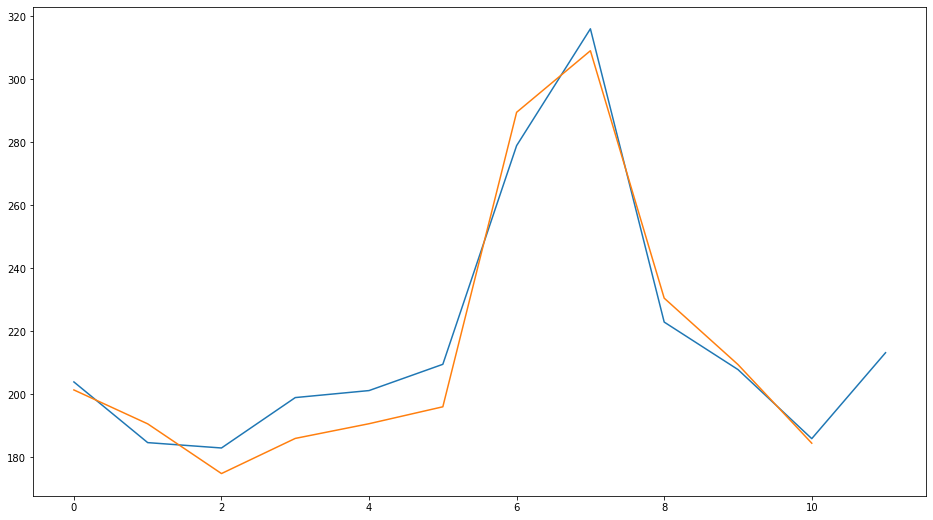

In [46]:
plt.plot(meses['2017'].values)
plt.plot(meses['2018'].values)

# Analisis:

Vemos que en 2017 (en azul) tenemos un inicio de año con un descenso en la cantidad de unidades, luego comienza a subir hasta la llegada del verano europeo en donde en los meses junio y julio tenemos la mayor cantidad de ventas. Finalmente vuelve a disminuir y tiene un pequeño pico en diciembre con la Navidad.

También vemos que 2018 (naranja) se comporta prácticamente igual. Es decir que pareciera que tenemos una estacionalidad. Por ejemplo podríamos aventurarnos a pronosticar que “el verano de 2019 también tendrá un pico de ventas”.

# Visualización de medias diarias

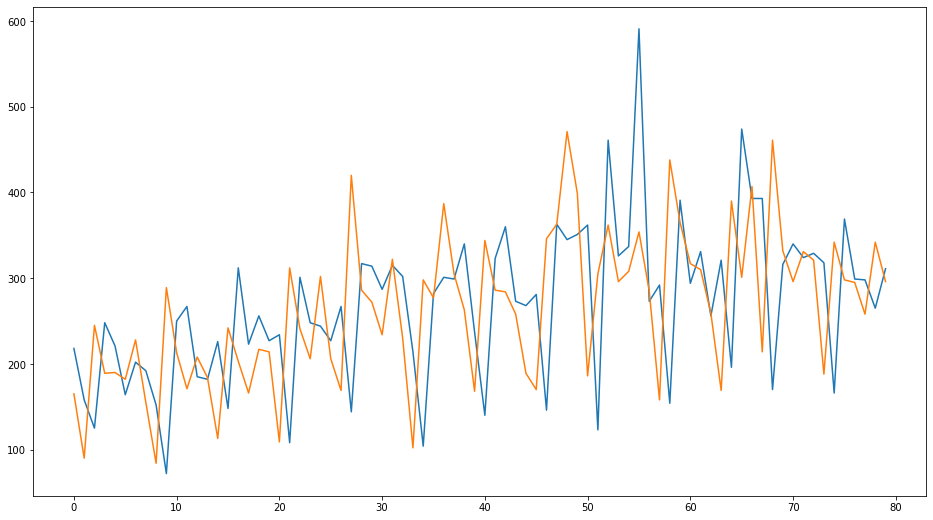

In [47]:
verano2017 = df['2017-06-01':'2017-09-01']
plt.plot(verano2017.values)
verano2018 = df['2018-06-01':'2018-09-01']
plt.plot(verano2018.values)

Una vez que se confirma que la serie es estacionaria, podemos hacer pronóstico. Existen diversos métodos para hacer pronóstico. Para este caso, las ventas parecen comportarse bastante parecidas de un año a otro, con lo cual un método sencillo si por ejemplo quisiéramos proveer el stock que necesitaría este comercio, sería decir “Si en 2017 en diciembre vendimos promedio 213 unidades, pronostico que en diciembre 2018 será similar”

# Pronóstico de Ventas Diarias con Redes FeedForward

Para este ejemplo usaremos una arquitectura de red neuronal FeedForward (también llamada MLP por sus siglas Multi-Layered Perceptron), con pocas neuronas y como método de activación tangente hiperbólica pues entregaremos valores transformados entre -1 y 1.

Alteraremos nuestro flujo de entrada del archivo csv que contiene una columna con las unidades despachadas, y lo convertiremos en varias columnas. Lo que haremos es tomar nuestra serie temporal y la convertiremos en un “problema de tipo supervisado“ para poder alimentar nuestra red neuronal y poder entrenarla con backpropagation. Para hacerlo, debemos tener unas entradas y unas salidas para entrenar al modelo.

Lo que haremos en este ejemplo es tomar los 7 días previos para “obtener” el octavo. Podríamos intentar entrenar a la red con 2, ó 3 días o también podríamos tener 1 sola salida, ó hasta intentar predecir más de un “día futuro”.

Entradas: serán “7 columnas” que representan las ventas en unidades de los 7 días anteriores.
    
Salida: El valor del “8vo día”. Es decir, las ventas (en unids) de ese día.

In [219]:
PASOS=7

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    #print(data.shape)
    n_vars = 1 if type(data) is list else data.shape[1]
    #print(n_vars,n_in,n_out)
    df = pd.DataFrame(data)
    
    #se 2 listas con columnas y nombres
    cols,cols2, names = list(), list(),list()
    
    
    
# input sequence (t-n, ... t-1)
#Eje names: ['var1(t-7)', 'var1(t-6)']
    
    #7 6 5 4 3 2 1, el menos 1 indica que va regresivo de n_in a 0
    #['var1(t-7)', 'var1(t-6)', 'var1(t-5)', 'var1(t-4)', 'var1(t-3)', 'var1(t-2)', 'var1(t-1)']
    for i in range(n_in,0,-1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    #print(names)

    #print(len(cols))
        
#    forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
#axis{0/’index’, 1/’columns’}, default 0
# put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
   
    #print(agg)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg

# load dataset
values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))

#N cantidad de filas(-1), 1 dimension
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension

scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.head()
#reframed.to_csv("data_time_series_reframe.csv", index=False)
#print(len(reframed))

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,-0.314815,-0.311111,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333
8,-0.311111,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407
9,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222
10,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444
11,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444,-0.344444


In [91]:
#ejemplo reshape,convierte matriz de 4x2 en matrix de nx4
#    array_2d = np.array([[1,2],
#                  [4,5],
#                  [6,7],
#                  [8,9]])

#array_2d.reshape(-1, 4)

Usaremos como entradas las columnas encabezadas como var1(t-7) a (t-1) y nuestra salida (lo que sería el valor “Y” de la función) será el var1(t) -la última columna-.

# Creación Red Neuronal

Antes de crear la red neuronal, se subdivide el conjunto de datos en train y en test. Algo importante de este procedimiento, a diferencia de en otros problemas en los que se puede “mezclar” los datos de entrada, es que en este caso nos importa mantener el orden en el que alimentaremos la red. Por lo tanto, haremos una subdivisión de los primeros 567 días consecutivos para entrenamiento de la red y los siguientes 30 para su validación. 

Esta es una proporción al azar, puede no ser la óptima, se puede variar esta proporción en 80-20 y comparar resultados.

In [235]:
# split into train and test sets
values = reframed.values
#315 2017
#289 2018

n_train_days = 315+289 - (30+PASOS)
#567

train = values[:n_train_days, :]
test = values[n_train_days:, :]


# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]



# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(567, 1, 7) (567,) (30, 1, 7) (30,)


Hemos transformado la entrada en un arreglo con forma (567,1,7) - “567 entradas con vectores de 1×7”.

La arquitectura de la red neuronal será:

-Entrada 7 inputs, como dijimos antes

-1 capa oculta con 7 neuronas (este valor puede variar)

-La salida será 1 sola neurona

-Como función de activación utilizamos tangente hiperbólica puesto que utilizaremos valores entre -1 y 1.

-Utilizaremos como optimizador Adam y métrica de pérdida (loss) Mean Absolute Error

-Como la predicción será un valor "continuo" y no "discreto", para calcular el Acuracy utilizaremos Mean Squared Error y para saber si mejora con el entrenamiento se debería ir reduciendo con las EPOCHS.

In [236]:
def crear_modeloFF():
    model = Sequential() 
    #(567, 1, 7) INPUT_SHAPE-> 1, 7
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model


In [256]:
EPOCHS=100

model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1, 7)              56        
_________________________________________________________________
flatten_2 (Flatten)          (None, 7)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 8         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
81/81 [==============================] - 2s 5ms/step - loss: 0.6238 - mse: 0.5003 - val_loss: 0.2030 - val_mse: 0.0609
Epoch 2/100
81/81 [==============================] - 0s 1ms/step - loss: 0.2121 - mse: 0.0744 - val_loss: 0.1659 - val_mse: 0.0439
Epoch 3/100
81/81 [==============================] - 0s 1ms/step - loss: 0.1989 - mse: 0.0662 - val_loss: 0.1584 - val_mse: 0.

81/81 [==============================] - 0s 1ms/step - loss: 0.1675 - mse: 0.0525 - val_loss: 0.1428 - val_mse: 0.0362
Epoch 58/100
81/81 [==============================] - 0s 1ms/step - loss: 0.1599 - mse: 0.0470 - val_loss: 0.1425 - val_mse: 0.0361
Epoch 59/100
81/81 [==============================] - 0s 1ms/step - loss: 0.1573 - mse: 0.0459 - val_loss: 0.1407 - val_mse: 0.0364
Epoch 60/100
81/81 [==============================] - 0s 1ms/step - loss: 0.1738 - mse: 0.0601 - val_loss: 0.1428 - val_mse: 0.0361
Epoch 61/100
81/81 [==============================] - 0s 1ms/step - loss: 0.1661 - mse: 0.0512 - val_loss: 0.1413 - val_mse: 0.0367
Epoch 62/100
81/81 [==============================] - 0s 1ms/step - loss: 0.1673 - mse: 0.0573 - val_loss: 0.1427 - val_mse: 0.0362
Epoch 63/100
81/81 [==============================] - 0s 1ms/step - loss: 0.1543 - mse: 0.0494 - val_loss: 0.1424 - val_mse: 0.0372
Epoch 64/100
81/81 [==============================] - 0s 1ms/step - loss: 0.1621 - mse: 0

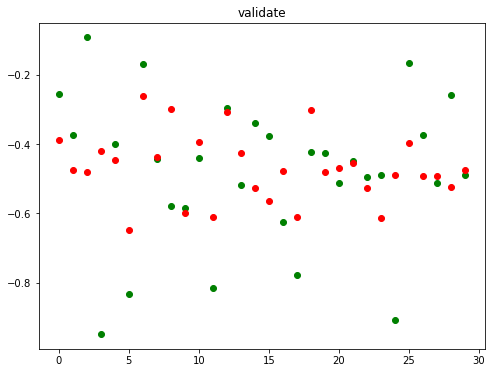

In [257]:
results=model.predict(x_val)
plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

En la gráfica vemos que los puntos verdes intentan aproximarse a los rojos. 

Cuanto más cerca ó superpuestos mejor. 

Si se aumenta la cantidad de EPOCHS mejora cada vez más.

Veamos y comparemos también cómo disminuye el LOSS tanto en el conjunto de train como el de Validate, esto es bueno ya que indica que el modelo está aprendiendo. A su vez pareciera no haber overfitting, pues las curvas de train y validate son distintas.

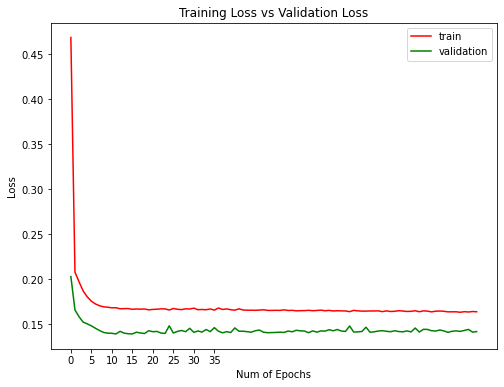

In [258]:
#plt.figure(0)  
#plt.plot(history.history['mse'],'r')  
#plt.plot(history.history['val_mse'],'g')  
#plt.xticks(np.arange(0, 11, 2.0))  
#plt.rcParams['figure.figsize'] = (8, 6)  
#plt.xlabel("Num of Epochs")  
#plt.ylabel("Accuracy")  
#plt.title("Training Accuracy vs Validation Accuracy")  
#plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history.history['loss'],'r')  
plt.plot(history.history['val_loss'],'g')  
plt.xticks(np.arange(0, 40, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show()  

# Pronóstico de ventas futuras

Ahora que tenemos la red -suponiendo que realizamos los 7 pasos del ML– probaremos a realizar una nueva predicción, en este caso, usaremos los últimos días de noviembre 2018 para calcular la primer semana de diciembre. Veamos:

In [259]:
ultimosDias = df['2018-11-16':'2018-11-30']
ultimosDias

fecha
2018-11-16    152
2018-11-17    111
2018-11-19    207
2018-11-20    206
2018-11-21    183
2018-11-22    200
2018-11-23    187
2018-11-24    189
2018-11-25     76
2018-11-26    276
2018-11-27    220
2018-11-28    183
2018-11-29    251
2018-11-30    189
Name: unidades, dtype: int64

In [271]:
values = ultimosDias.values
values = values.astype('float32')
# normalize features
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, PASOS, 1)
#axis{0/’index’, 1/’columns’}, default 0
reframed.drop(reframed.columns[[7]], axis=1, inplace=True)
reframed.head(-1)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
7,-0.24,-0.65,0.31,0.30,0.07,0.24,0.11
8,-0.65,0.31,0.30,0.07,0.24,0.11,0.13
9,0.31,0.30,0.07,0.24,0.11,0.13,-1.00
10,0.30,0.07,0.24,0.11,0.13,-1.00,1.00
11,0.07,0.24,0.11,0.13,-1.00,1.00,0.44
12,0.24,0.11,0.13,-1.00,1.00,0.44,0.07


De este conjunto “ultimosDias” tomamos sólo la última fila, pues es la que correspondería a la última semana de noviembre y la dejamos en el formato correcto para la red neuronal con reshape:

In [298]:
values = reframed.values
x_test = values[6:, :]
x_test = x_test.reshape((x_test.shape[0],1, x_test.shape[1]))
x_test.shape


(1, 1, 7)

Ahora crearemos una función para ir “rellenando” el desplazamiento que hacemos por cada predicción. Esto es porque queremos predecir los 7 primeros días de diciembre. Entonces para el 1 de diciembre, ya tenemos el set con los últimos 7 días de noviembre. Pero para pronosticar el 2 de diciembre necesitamos los 7 días anteriores que INCLUYEN al 1 de diciembre y ese valor, lo obtenemos en nuestra predicción anterior. Y así hasta el 7 de diciembre.

In [317]:
#x_test.shape[2]
def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        #print(i)
        x_test[0][0][i] = x_test[0][0][i+1]
        if i ==3:
            break
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test

results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    #print(parcial[0])
    x_test=agregarNuevoValor(x_test,parcial[0])

Ahora las predicciones están en el dominio del -1 al 1 y nosotros lo queremos en nuestra escala “real” de unidades vendidas. Entonces vamos a “re-transformar” los datos con el objeto “scaler” que creamos antes.

In [320]:
adimen = [x for x in results]    
inverted = scaler.inverse_transform(adimen)
inverted

array([[128.36674739],
       [128.36674739],
       [128.36674739],
       [128.36674739],
       [128.36674739],
       [128.36674739],
       [128.36674739]])